In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
from datetime import datetime
from itertools import groupby
import os

In [2]:
path = r'T:\DCProjects\Modeling\AADBT\data\Strava'

In [3]:
eug_cob = pd.read_csv(path+'\\EugCob_daily_2018-01-01-2021-12-31_ride\EugCob_Daily_Strava.csv')

In [4]:
spr = pd.read_csv(path+'\\Spr_daily_2018-01-01-2021-12-31_ride\Spr_Daily_Strava.csv')

In [5]:
data = eug_cob.append(spr, ignore_index=True)

In [6]:
data.drop_duplicates(inplace=True, ignore_index=True)

In [7]:
len(data.edge_uid.values)

1361237

In [8]:
len(eug_cob.edge_uid.unique())

14089

In [9]:
len(spr.edge_uid.unique())

4580

In [10]:
aggdata = data[["edge_uid", "date", "total_trip_count"]].groupby("edge_uid", as_index=False).agg("mean")

In [11]:
aggdata.head(3)

,edge_uid,total_trip_count
0,314113123,5.0
1,314114855,5.0
2,314114857,5.0


In [12]:
aggdata.shape

(18669, 2)

In [13]:
any(ID in eug_cob.edge_uid.unique() for ID in spr.edge_uid.unique())

False

In [14]:
gdb = r'T:\DCProjects\Modeling\AADBT\data\Predictors\Predictors.gdb'

In [15]:
eugcob_data = gpd.read_file(gdb, layer='EugCob_Daily_S_ExportFeature')

In [16]:
spr_data = gpd.read_file(gdb, layer='Spr_Daily_Stra_ExportFeature')

In [17]:
eugcob_data.shape

(52486, 4)

In [18]:
len(eugcob_data.edgeUID.unique())

52486

In [19]:
all(ID in eugcob_data.edgeUID.unique() for ID in eug_cob.edge_uid.unique())

True

In [20]:
spr_data.shape

(14342, 4)

In [21]:
sp_data = eugcob_data.append(spr_data)

In [22]:
sp_merged = sp_data.merge(aggdata[['edge_uid', 'total_trip_count']], how= 'right', 
                              left_on = 'edgeUID', right_on = 'edge_uid')

In [23]:
sp_merged.head(3)

,edgeUID,osmId,Shape_Length,geometry,edge_uid,total_trip_count
0,314113123,921107806,0.009976,"MULTILINESTRING ((-123.04385 44.01051, -123.04...",314113123,5.0
1,314114855,958092094,0.003308,"MULTILINESTRING ((-123.06036 44.01126, -123.05...",314114855,5.0
2,314114857,958092094,0.000318,"MULTILINESTRING ((-123.05679 44.01147, -123.05...",314114857,5.0


In [24]:
sp_merged.total_trip_count.describe()

count    18669.000000
mean         7.297080
std         11.720496
min          5.000000
25%          5.000000
50%          5.294118
75%          6.666667
max        333.750000
Name: total_trip_count, dtype: float64

In [25]:
outpath = r'T:\DCProjects\Modeling\AADBT\input'

In [26]:
bike_counts_loc = gpd.read_file(outpath + '\shp\BikeCountsLocations.shp')

In [27]:
sp_merged = sp_merged.to_crs(epsg=3857)

In [28]:
sp_merged.shape

(18669, 6)

In [29]:
len(sp_merged.edgeUID.unique())

18669

In [30]:
bike_counts_loc = bike_counts_loc.to_crs(epsg=3857)

In [31]:
bike_counts_loc.shape

(205, 2)

In [32]:
bikecountloc_near_Strava = gpd.sjoin_nearest(bike_counts_loc, sp_merged, distance_col="distances", how="left")

In [33]:
bikecountloc_near_Strava.head()

,Location,geometry,index_right,edgeUID,osmId,Shape_Length,edge_uid,total_trip_count,distances
0,EastAmazonSouth39th,POINT (-13700851.461 5467390.544),5873,333060821,955069513,0.000078,333060821,10.555556,40.239361
1,KincaidSouth37th,POINT (-13700769.864 5467802.900),5883,333060893,5486121,0.001930,333060893,10.555556,104.306488
2,HilyardSouth33rdWestSidewalk,POINT (-13701392.029 5468580.143),5872,333060691,667025370,0.000077,333060691,15.000000,41.731876
3,HilyardSouth33rdEastSidewalk,POINT (-13701353.512 5468596.552),5890,333060930,122901738,0.009331,333060930,10.555556,1.766442
4,EastAmazonEastHilyardWestSidewalk,POINT (-13701316.220 5468616.058),5890,333060930,122901738,0.009331,333060930,10.555556,8.724466


In [34]:
bikecountloc_near_Strava.distances.describe()

count    223.000000
mean      43.941568
std       87.271718
min        0.069499
25%        1.764495
50%        7.586979
75%       46.435731
max      733.469625
Name: distances, dtype: float64

In [35]:
bikecountloc_near_Strava.total_trip_count.isna().sum()

0

In [36]:
df = pd.read_csv(outpath+'\\Daily_Bike_Counts_With_AllVarData.csv')

In [37]:
MPObd = gpd.read_file("X:/Data/Transportation/MPO_Bound.shp")

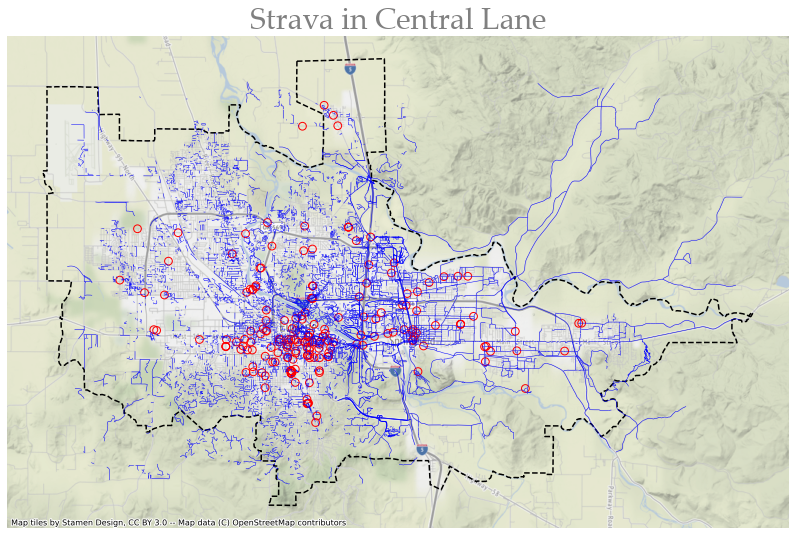

In [38]:
fig, ax = plt.subplots(figsize=(14, 12))
sp_merged.plot(ax=ax, color='blue', linewidth = 0.5, aspect=1)
bike_counts_loc.plot(ax=ax, marker ='o', facecolor="none", edgecolor="red", markersize=60, aspect=1)
MPObd.plot(ax=ax, facecolor="none", edgecolor="black", linestyle='--', linewidth = 1.5, aspect=1)
ctx.add_basemap(ax, alpha = 0.7)
plt.title("Strava in Central Lane", fontsize=30, fontname="Palatino Linotype", 
          color="grey")
ax.axis("off");

In [39]:
sp_merged.rename(columns={'Shape_Length': 'Shp_Length', 'total_trip_count':'total_cnt'}, inplace=True)

In [40]:
sp_merged.to_file(os.path.join(path, "aggregated_Strava_data.shp"))